In [1]:
# Inference with Segment-NT models

## Installation and imports

In [2]:
!pip install biopython

In [3]:
from Bio import SeqIO
import gzip
import numpy as np
import transformers
from transformers import AutoTokenizer, AutoModel
import torch

## Download the model
The following cell allows you to download the config and the model of one of the Segment-NT models.

In [4]:
# Load model directly
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/segment_nt", trust_remote_code=True)
model = AutoModel.from_pretrained("InstaDeepAI/segment_nt", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:720: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:466: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


In [5]:
# The number of DNA tokens (excluding the CLS token prepended) needs to be dividible by
# the square of the number of downsampling block in SegmentNT UNet head, i.e 4.
# In the paper and in the jax colab, the length is set at 8333 tokens, which corresponds
# to 49992 nucleotides. On Google Colab, the inference with this length fits on the
# JAX model but does not fit in the Torch model. Therefore, we select here a slightly
# smaller length.
max_num_dna_tokens = 8200

# If max_num_tokens is larger than what was used to train Segment-NT, the rescaling
# factor needs to be adapted.
if max_num_dna_tokens + 1 > 5001:
    inference_rescaling_factor = (max_num_dna_tokens + 1) / 2048

    # Apply the new rescaling factor to all Rotary Embeddings layer.
    num_layers = len(model.esm.encoder.layer)

    for layer in range(num_layers):
      model.esm.encoder.layer[layer].attention.self.rotary_embeddings.rescaling_factor = inference_rescaling_factor
else:
    inference_rescaling_factor = None



# Get data

To reproduce the Fig.3 of the Segment-NT paper, we retrieve here the file of the human chromosome 20 and select the corresponding 50kb sequence.

### Download fasta file of chromosome 20 of the human genome

In [6]:
! wget https://ftp.ensembl.org/pub/release-111/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.20.fa.gz

--2024-03-14 14:14:15--  https://ftp.ensembl.org/pub/release-111/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.20.fa.gz
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.193.169
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.193.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18833053 (18M) [application/x-gzip]
Saving to: ‘Homo_sapiens.GRCh38.dna.chromosome.20.fa.gz.13’

Homo_sapiens.GRCh38 100%[===================>]  17.96M  5.69MB/s    in 3.2s    

2024-03-14 14:14:18 (5.69 MB/s) - ‘Homo_sapiens.GRCh38.dna.chromosome.20.fa.gz.13’ saved [18833053/18833053]



### Load sequence from chromosome and tokenize it

In [7]:
fasta_path = "Homo_sapiens.GRCh38.dna.chromosome.20.fa.gz"

with gzip.open(fasta_path, "rt") as handle:
    record = next(SeqIO.parse(handle, "fasta"))
    chr20 = str(record.seq)

In [8]:
idx_start = 5100000
idx_stop = idx_start + max_num_dna_tokens*6

sequences = [chr20[idx_start:idx_stop]]
tokens = tokenizer.batch_encode_plus(sequences, return_tensors="pt", padding="max_length", max_length = max_num_dna_tokens)["input_ids"]


# Infer the probabilities for 14 genomic features

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.cuda()

SegmentNT(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(4107, 1024, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(2050, 1024, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-28): 29 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((1024,), eps=1e-12, ele

In [10]:
# Infer
tokens = tokens.cuda()
attention_mask = (tokens != tokenizer.pad_token_id).cuda()
with torch.no_grad():
  outs = model(
      tokens,
      attention_mask=attention_mask,
  )

In [11]:
# Obtain the logits over the genomic features
logits = outs["logits"]
# Transform them on probabilities
probabilities = np.asarray(torch.nn.functional.softmax(logits, dim=-1).cpu())[...,-1]

# Plot predictions

In [12]:
import seaborn as sns
from typing import List
import matplotlib.pyplot as plt

# seaborn settings
sns.set_style("whitegrid")
sns.set_context(
    "notebook",
    font_scale=1,
    rc={
        "font.size": 14,
        "axes.titlesize": 18,
        "axes.labelsize": 18,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 16,
        }
)

plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

# set colors
colors = sns.color_palette("Set2").as_hex()
colors2 = sns.color_palette("husl").as_hex()

In [13]:
def plot_features(
    predicted_probabilities_all,
    seq_length: int,
    features: List[str],
    order_to_plot: List[str],
    fig_width=8,
):
    """
    Function to plot labels and predicted probabilities.

    Args:
        predicted_probabilities_all: Probabilities per genomic feature for each
            nucleotides in the DNA sequence.
        seq_length: DNA sequence length.
        feature: Genomic features to plot.
        order_to_plot: Order in which to plot the genomic features. This needs to be
            specified in order to match the order presented in the Fig.3 of the paper
        fig_width: Width of the figure
    """

    sc = 1.8
    n_panels = 7

    # fig, axes = plt.subplots(n_panels, 1, figsize=(fig_width * sc, (n_panels + 2) * sc), height_ratios=[6] + [2] * (n_panels-1))
    _, axes = plt.subplots(n_panels, 1, figsize=(fig_width * sc, (n_panels + 4) * sc))

    for n, feat in enumerate(order_to_plot):
        feat_id = features.index(feat)
        prob_dist = predicted_probabilities_all[:, feat_id]

        # Use the appropriate subplot
        ax = axes[n // 2]

        try:
            id_color = colors[feat_id]
        except:
            id_color = colors2[feat_id - 8]
        ax.plot(
            prob_dist,
            color=id_color,
            label=feat,
            linestyle="-",
            linewidth=1.5,
        )
        ax.set_xlim(0, seq_length)
        ax.grid(False)
        ax.spines['bottom'].set_color('black')
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['left'].set_color('black')

    for a in range (0,n_panels):
        axes[a].set_ylim(0, 1.05)
        axes[a].set_ylabel("Prob.")
        axes[a].legend(loc="upper left", bbox_to_anchor=(1, 1), borderaxespad=0)
        if a != (n_panels-1):
            axes[a].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)

    # Set common x-axis label
    axes[-1].set_xlabel("Nucleotides")
    # axes[0].axis('off')  # Turn off the axis
    axes[n_panels-1].grid(False)
    axes[n_panels-1].tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False)

    axes[0].set_title("Probabilities predicted over all genomics features", fontweight="bold")

    plt.show()


In [14]:
# Rearrange order of the features to match Fig.3 from the paper
features_rearranged = [
 'protein_coding_gene',
 'lncRNA',
 '5UTR',
 '3UTR',
 'exon',
 'intron',
 'splice_donor',
 'splice_acceptor',
 'promoter_Tissue_specific',
 'promoter_Tissue_invariant',
 'enhancer_Tissue_specific',
 'enhancer_Tissue_invariant',
 'CTCF-bound',
 'polyA_signal',
]

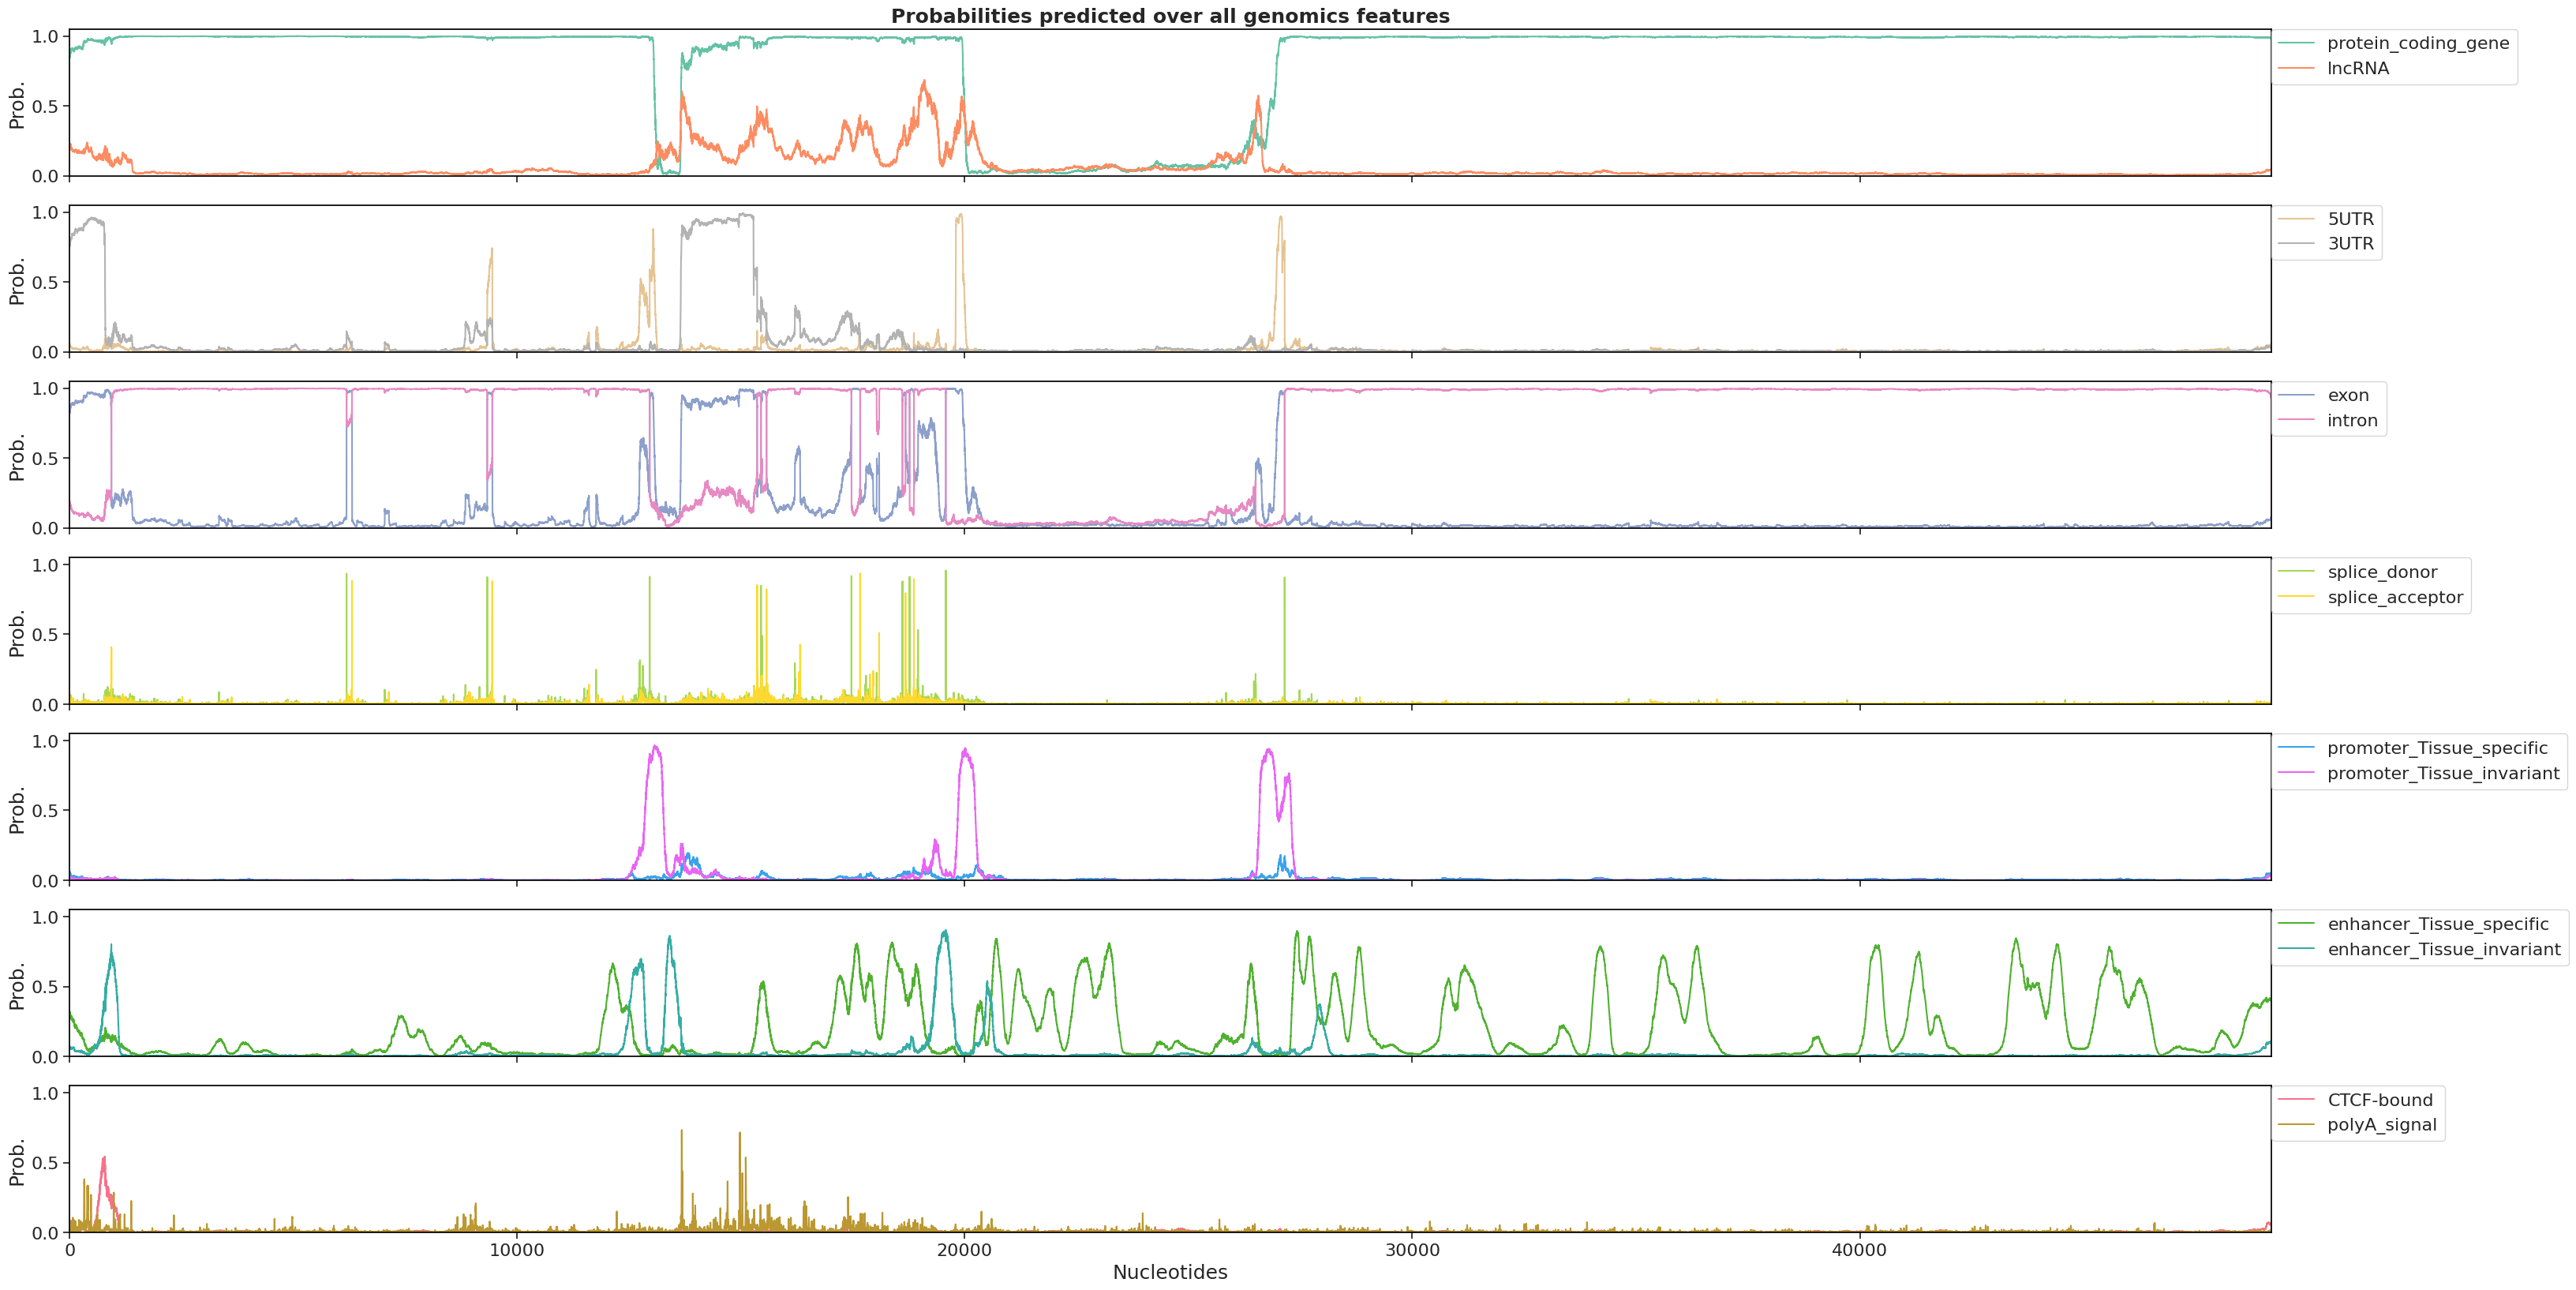

In [15]:
plot_features(
    probabilities[0],
    probabilities.shape[-2],
    fig_width=20,
    features=model.config.features,
    order_to_plot=features_rearranged
)